#Objective

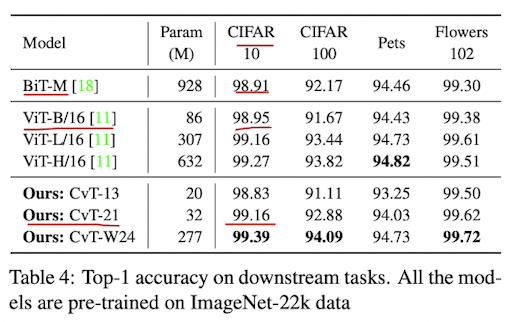
- Verify the performance of the CvT model by running the downstream task for CIFAR-10
- BiT-M-50x3 Model is pre-trained on ImageNet-22k
- As a result of the experiment, CvT showed the best performance even though it took less training time.

## All of these codes are not in the paper. To verify the paper's experiment, I reproduced the codes by referring to the content learned in this course and the codes in the references.

## How to fine-tuning the model
Fine-tuning takes a long time. 

Thus, we repeated training: load model, train five epochs and save model

There are some {epoch.pth} files per model. 
- models (folder): BiT-M-{N}epoch.pth, ViT-L-{N}epoch.pth, CvT-21-{N}epoch.pth

As a result, we trained each model for 15 epochs.

## Setup Environment

In [ ]:
!nvidia-smi

Sun May 22 12:23:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import time
import re

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Data (CIFAR-10)

In [ ]:
batch_size = 8
num_classes = 10
num_epochs = 5

pre_epochs = 10 # epochs to start training

In [ ]:
train_transforms = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                ])
train_set = torchvision.datasets.CIFAR10("./", train=True, 
                                         download=True, 
                                         transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

test_set = torchvision.datasets.CIFAR10("./", train=False, 
                                        download=True, 
                                        transform=test_transforms)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels)

torch.Size([8, 3, 224, 224])
tensor([7, 8, 9, 9, 9, 8, 6, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


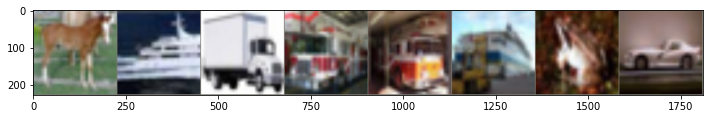

	horse 	ship 	truck 	truck 	truck 	ship 	frog 	car


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# Inverse the normalisation
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def imshow(img):
    img = inverse_normalize(tensor=img, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))  
    npimg = img.numpy()
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(batch_size)))

## Install Library and Pre-trained Model Weights
 - Install and unzip the github zip file using git clone
 - https://github.com/google-research/big_transfer

In [ ]:
cd /content/gdrive/MyDrive/FinalProject/FineTuning

/content/gdrive/MyDrive/FinalProject/FineTuning


In [ ]:
!git clone https://github.com/google-research/big_transfer.git

Cloning into 'big_transfer'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 109 (delta 6), reused 6 (delta 2), pack-reused 91
Receiving objects: 100% (109/109), 862.36 KiB | 11.65 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
cd /content/gdrive/MyDrive/FinalProject/FineTuning/big_transfer

/content/gdrive/MyDrive/FinalProject/FineTuning/big_transfer


In [ ]:
!pip install -r bit_pytorch/requirements.txt

In [ ]:
!wget https://storage.googleapis.com/bit_models/BiT-M-R50x3.npz

--2022-05-27 05:23:24--  https://storage.googleapis.com/bit_models/BiT-M-R50x3.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.18.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1381642520 (1.3G) [application/octet-stream]
Saving to: ‘BiT-M-R50x3.npz’

BiT-M-R50x3.npz     100%[===================>]   1.29G   107MB/s    in 14s     

2022-05-27 05:23:38 (93.5 MB/s) - ‘BiT-M-R50x3.npz’ saved [1381642520/1381642520]



## Load Model
 - ImageNet-22k, 224x24, Pre-trained model BiT-M-R50x1

In [ ]:
import bit_pytorch.models as models

# For Fine tuning, head_size = num_classes, zero_head = True
model = models.KNOWN_MODELS['BiT-M-R50x3'](head_size=num_classes, zero_head = True).to(device)

# For First Fine Tuning
# Pre-trained on ImageNet 22k
model.load_from(np.load("BiT-M-R50x3.npz"))

## Store the pth file in FineTuning folder (not in big_transformers folder)
 - maintain the pth file (of ViT, BiT, CvT) in the same folder!

In [ ]:
cd /content/gdrive/MyDrive/FinalProject/FineTuning

/content/gdrive/MyDrive/FinalProject/FineTuning


## Load the Previously Trained Model
 - Restrucht the last layer is not needed
 - The last output is already 10

In [ ]:
model.head

Sequential(
  (gn): GroupNorm(32, 6144, eps=1e-05, affine=True)
  (relu): ReLU(inplace=True)
  (avg): AdaptiveAvgPool2d(output_size=1)
  (conv): Conv2d(6144, 10, kernel_size=(1, 1), stride=(1, 1))
)

 - If Start Epoch is 0

In [ ]:
# If start epoch is 0, skip this sector

 - If Start Epoch is bigger than 0

In [ ]:
# If start epoch is bigger than 0

if pre_epochs > 0:
    # load trained model before
    PATH = f'./models/BiT-M-{pre_epochs}epoch.pth'

    # apply the paramters to model
    model.load_state_dict(torch.load(PATH))
    model = model.to(device)

## Fine Tuning Strategy
 - In situations where there are many classes in downstream task, problems with low performance can occur

 - When the number of labels for the target task is large, perform backpropagation on every feature extractor will be better.

 - To obtaion the high accuracy, we finetuned on full layers
 - https://wandb.ai/suvadeep/pytorch/reports/Finetuning-of-ResNet-18-on-CIFAR-10-Dataset--VmlldzoxMDE2NjQ1
 - https://androidkt.com/pytorch-freeze-layer-fixed-feature-extractor-transfer-learning/
 - https://androidkt.com/modify-pre-train-pytorch-model-for-finetuning-and-feature-extraction/

In [ ]:
params_to_update = []

for name, param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print(name) # param to update. (it is same to whole parameters in model)

# Loss and Optimiser
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

root.conv.weight
body.block1.unit01.gn1.weight
body.block1.unit01.gn1.bias
body.block1.unit01.conv1.weight
body.block1.unit01.gn2.weight
body.block1.unit01.gn2.bias
body.block1.unit01.conv2.weight
body.block1.unit01.gn3.weight
body.block1.unit01.gn3.bias
body.block1.unit01.conv3.weight
body.block1.unit01.downsample.weight
body.block1.unit02.gn1.weight
body.block1.unit02.gn1.bias
body.block1.unit02.conv1.weight
body.block1.unit02.gn2.weight
body.block1.unit02.gn2.bias
body.block1.unit02.conv2.weight
body.block1.unit02.gn3.weight
body.block1.unit02.gn3.bias
body.block1.unit02.conv3.weight
body.block1.unit03.gn1.weight
body.block1.unit03.gn1.bias
body.block1.unit03.conv1.weight
body.block1.unit03.gn2.weight
body.block1.unit03.gn2.bias
body.block1.unit03.conv2.weight
body.block1.unit03.gn3.weight
body.block1.unit03.gn3.bias
body.block1.unit03.conv3.weight
body.block2.unit01.gn1.weight
body.block2.unit01.gn1.bias
body.block2.unit01.conv1.weight
body.block2.unit01.gn2.weight
body.block2.unit

In [ ]:
# (number of images, number of output classes)
model(images.to(device)).shape

torch.Size([8, 10])

## Train (Fine Tuning)
 - ImageNet, 224x24, Pre-trained model BiT-M-R50x3 Fine-tuning on CIFAR-10

In [ ]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) 
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

start = time.time()

# iterate 'pre_epoch' to 'pre_epoch + num_epohcs'
for epoch in range(pre_epochs, num_epochs + pre_epochs):
  print("\n")
  for i, (images, labels) in enumerate(train_loader):
    model.train()                               

    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)                         
    loss = criterion(outputs, labels)               

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) % ((n_total_steps//batch_size)//5) == 0:
      print(f'Epoch {epoch+1}/{num_epochs + pre_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item()} ')

fine_tuning_time = time.time() - start

Total steps: 50000
Iterations per epoch: 6250


Epoch 11/15, Iteration 1250/6250, Loss=0.013028167188167572 
Epoch 11/15, Iteration 2500/6250, Loss=0.001760426559485495 
Epoch 11/15, Iteration 3750/6250, Loss=0.0198329146951437 
Epoch 11/15, Iteration 5000/6250, Loss=0.0002649917150847614 
Epoch 11/15, Iteration 6250/6250, Loss=1.0579577065072954e-05 


Epoch 12/15, Iteration 1250/6250, Loss=0.00031350660719908774 
Epoch 12/15, Iteration 2500/6250, Loss=4.7683636239526095e-07 
Epoch 12/15, Iteration 3750/6250, Loss=3.9189458220789675e-06 
Epoch 12/15, Iteration 5000/6250, Loss=1.8030293631454697e-06 
Epoch 12/15, Iteration 6250/6250, Loss=3.963673407270107e-06 


Epoch 13/15, Iteration 1250/6250, Loss=2.1755618035967927e-06 
Epoch 13/15, Iteration 2500/6250, Loss=0.000980301178060472 
Epoch 13/15, Iteration 3750/6250, Loss=4.366924622445367e-05 
Epoch 13/15, Iteration 5000/6250, Loss=0.09616866707801819 
Epoch 13/15, Iteration 6250/6250, Loss=0.0887640118598938 


Epoch 14/15, Iteratio

## Test

In [ ]:
# Formating Function
def nFormat(n):
    s = str(n)
    result = ""
    while True:
        if len(s) > 3:
            result = "," + s[-3:] + result
            s = s[:-3]
        else:
            result = s + result
            break
    return result

def tFormat(n):
    n = int(n)
    second = n%60
    minute = n//60
    return f'{minute}m {second}s'

In [ ]:
print('Final Epochs=',pre_epochs+num_epochs)
start = time.time()

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # Get predictions
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

test_time = time.time() - start

Final Epochs= 15
Test Accuracy of the WHOLE CNN = 96.26 %
Accuracy of plane: 97.7 %
Accuracy of car: 97.4 %
Accuracy of bird: 95.6 %
Accuracy of cat: 88.3 %
Accuracy of deer: 97.0 %
Accuracy of dog: 96.4 %
Accuracy of frog: 98.6 %
Accuracy of horse: 96.9 %
Accuracy of ship: 97.2 %
Accuracy of truck: 97.5 %


In [ ]:
print('Number of Parameters: ',nFormat(sum(p.numel() for p in model.parameters())))
print('Fine-tuning Time per 5 epoch: ',tFormat(fine_tuning_time))
print('Test Time: ',tFormat(test_time))

Number of Parameters:  211,235,530
Fine-tuning Time per 5 epoch:  188m 20s
Test Time:  2m 14s


## Save Model

In [ ]:
PATH = f'./models/BiT-M-{pre_epochs + num_epochs}epoch.pth'
torch.save(model.state_dict(), PATH)

## Check the Load and Save Correctly
 - To verify the loading weights from .pth file correctly, reload the model and test it!
 - The test accuarcy must exactly same.

In [ ]:
# reload the init model
model = models.KNOWN_MODELS['BiT-M-R50x3'](head_size=num_classes).to(device)

In [ ]:
# load the saved weights on the above
model.load_state_dict(torch.load(PATH))
model = model.to(device)

In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # Get predictions
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Test Accuracy of the WHOLE CNN = 96.26 %
Accuracy of plane: 97.7 %
Accuracy of car: 97.4 %
Accuracy of bird: 95.6 %
Accuracy of cat: 88.3 %
Accuracy of deer: 97.0 %
Accuracy of dog: 96.4 %
Accuracy of frog: 98.6 %
Accuracy of horse: 96.9 %
Accuracy of ship: 97.2 %
Accuracy of truck: 97.5 %


# Result
###CvT-21
 - Accuracy: 97.2%
 - Train Time: 94m 48s
 - Parameters: 31,241,546

###ViT-B-16
 - Accuracy: 96.18%
 - Train Time: 79m 44s
 - Parameters: 85,806,346

###BiT-M-R50x3
 - Accuracy: 96.26%
 - Train Time: 188m 20s
 - Parameters: 211,235,530

## References
 - https://github.com/google-research/big_transfer
 - https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html
 - https://arxiv.org/abs/2103.15808